<a href="https://colab.research.google.com/github/marfrlv/gpt-propaganda-detection/blob/main/SI_TC_all_conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# libraries
import pandas as pd
import os
from io import StringIO
import io
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
import json
import numpy as np
from statistics import mean, stdev

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Golden Dataset
golden_full_df_path = '/content/drive/MyDrive/thesis/semeval_2020_task_11_corpus/golden_labels_df_full.csv'
golden_full_df = pd.read_csv(golden_full_df_path)

# additional examples df
add_exm_df_path = '/content/drive/MyDrive/thesis/semeval_2020_task_11_corpus/additional_examples_for_chatgpt.csv'

# article IDs used in the experiment
article_ids_409_path = '/content/drive/MyDrive/thesis/article_IDs_exp_used.json'
with open(article_ids_409_path , 'r') as file:
  ids_409 = json.load(file)

# all articles folder path
all_art_fold_path = '/content/drive/MyDrive/thesis/all_articles'

golden_ids = golden_full_df['id'].nunique()
print(f'There are {golden_ids} unique IDs in the Golden Dataset.')
golden_labels_df_filtered = golden_full_df

There are 409 unique IDs in the Golden Dataset.


In [ ]:
def filter_df(df):
  df_filtered = df[(df["Text Span Presence"] != "False") & (df["Propaganda Technique"] != "irony") & (df["Propaganda Technique"] != "sarcasm") & (df["Propaganda Technique"] != "appeal_to_approach-avoidance")]
  return df_filtered

con1_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con1_final_df_aug24.csv'
con1_df = pd.read_csv(con1_df_path)
con1_df_filtered = filter_df(con1_df)

con2_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con2_final_df_aug24.csv'
con2_df = pd.read_csv(con2_df_path)
con2_df_filtered = filter_df(con2_df)

con3_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con3_final_df_aug24.csv'
con3_df = pd.read_csv(con3_df_path)
con3_df_filtered = filter_df(con3_df)

con4_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con4_final_df_aug24.csv'
con4_df = pd.read_csv(con4_df_path)
con4_df_filtered = filter_df(con4_df)


con5_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con5_final_df_aug24.csv'
con5_df = pd.read_csv(con5_df_path)
con5_df_filtered = filter_df(con5_df)

con6_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con6_final_df_aug24.csv'
con6_df = pd.read_csv(con6_df_path)
con6_df_filtered = filter_df(con6_df)

con7_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con7_final_df_aug24.csv'
con7_df = pd.read_csv(con7_df_path)
con7_df_filtered = filter_df(con7_df)

con8_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con8_final_df_aug24.csv'
con8_df = pd.read_csv(con8_df_path)
con8_df_filtered = filter_df(con8_df)

dfs_names = ["Condition 1 (Base 0ne-shot Temp0.7)", "Condition 2 (Base Few-shot Temp0.7)",
             "Condition 3 (CoT One-shot Temp0.7)", "Condition 4 (CoT Few-shot Temp0.7)",
             "Condition 5 (Base One-shot Temp 0)", "Condition 6 (Base Few-shot Temp 0)",
             "Condition 7 (CoT One-shot Temp 0)", "Condition 8 (CoT Few-shot Temp 0)"]
dfs = [con1_df, con2_df, con3_df, con4_df, con5_df, con6_df, con7_df, con8_df]
dfs_filtered = [con1_df_filtered, con2_df_filtered, con3_df_filtered, con4_df_filtered,
                con5_df_filtered, con6_df_filtered, con7_df_filtered, con8_df_filtered]

In [ ]:
def count_values(df, column):
  value_counts = df[column].value_counts()
  value_counts_percent = df[column].value_counts(normalize=True) * 100
  value_counts_percent = value_counts_percent.round(1)

  print(value_counts)
  print()
  print(value_counts_percent)

# SI Task

## Function to preprocess text spans

In [ ]:
# Ensure you have downloaded the necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_spans_by_steps(df, df_column):
    # Ensure the column is of string type
    df[df_column] = df[df_column].astype(str)

    # Define a set of punctuation marks to be removed
    punctuation_to_remove = set(string.punctuation)
    punctuation_to_remove.update({'“', '”', '‘', '’'})

    # Initialize stop words and lemmatizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Step 1: Remove punctuation
    def remove_punctuation(text):
        return ''.join(char for char in text if char not in punctuation_to_remove)

    df['step_1_no_punct'] = df[df_column].apply(remove_punctuation)

    # Step 2: Convert to lowercase
    def to_lowercase(text):
        return text.lower()

    df['step_2_lowercase'] = df['step_1_no_punct'].apply(to_lowercase)

    # Step 3: Tokenize, remove stop words, and convert back to continuous string
    def tokenize_and_remove_stopwords(text):
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(filtered_tokens)

    df['step_3_no_stopwords'] = df['step_2_lowercase'].apply(tokenize_and_remove_stopwords)

    # Step 4: Lemmatize and convert back to continuous string
    def lemmatize_text(text):
        tokens = word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)

    df['step_4_lemmatized'] = df['step_3_no_stopwords'].apply(lemmatize_text)

    return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
preprocessed_golden_labels_df = preprocess_spans_by_steps(golden_labels_df_filtered.copy(), 'text_span')
preprocessed_golden_labels_df

,id,technique,text_span,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized
0,111111111,appeal_to_authority,The next transmission could be more pronounced...,The next transmission could be more pronounced...,the next transmission could be more pronounced...,next transmission could pronounced stronger,next transmission could pronounced stronger
1,111111111,appeal_to_authority,when (the plague) comes again it starts from m...,when the plague comes again it starts from mor...,when the plague comes again it starts from mor...,plague comes starts stock magnitude next trans...,plague come start stock magnitude next transmi...
2,111111111,doubt,appeared,appeared,appeared,appeared,appeared
3,111111111,repetition,"a very, very different",a very very different,a very very different,different,different
4,111111111,appeal_to_fear-prejudice,He also pointed to the presence of the pneumon...,He also pointed to the presence of the pneumon...,he also pointed to the presence of the pneumon...,also pointed presence pneumonic version spread...,also pointed presence pneumonic version spread...
...,...,...,...,...,...,...,...
6062,111111121,no_propaganda_detected,no_propaganda_detected,nopropagandadetected,nopropagandadetected,nopropagandadetected,nopropagandadetected
6063,758385628,no_propaganda_detected,no_propaganda_detected,nopropagandadetected,nopropagandadetected,nopropagandadetected,nopropagandadetected
6064,754508491,no_propaganda_detected,no_propaganda_detected,nopropagandadetected,nopropagandadetected,nopropagandadetected,nopropagandadetected
6065,730652769,no_propaganda_detected,no_propaganda_detected,nopropagandadetected,nopropagandadetected,nopropagandadetected,nopropagandadetected


In [ ]:
def find_matching_spans(preprocessed_golden_df, df_filtered):
  preprocessed_df = preprocess_spans_by_steps(df_filtered.copy(), 'Text Span')

  def count_matching_text_spans(df1, column1, df2, column2):
    # convert the specified columns to lists and filter out empty strings
    list1 = [text_span for text_span in df1[column1].tolist() if text_span]
    list2 = [text_span for text_span in df2[column2].tolist() if text_span]

    # initialize match count and list
    match_count = 0
    match_spans = []

    # iterate through the first list and check for matches in the second list
    for text_span in list1:
        if text_span in list2:
            match_count += 1
            match_spans.append(text_span)

    return match_count, match_spans

  # count matches at each processing stage
  raw_count, raw_matches = count_matching_text_spans(preprocessed_golden_labels_df, 'text_span', preprocessed_df, 'Text Span')
  accuracy_score = raw_count / 6052

  print("Raw texts match count")
  print(f"Number of matching text spans: {raw_count}")
  print(f'Accuracy score: {accuracy_score:.2f}')
  print()
  print()
  print()

  print('No punctuation match count')
  count_1, matches_1 = count_matching_text_spans(preprocessed_golden_labels_df, 'step_1_no_punct', preprocessed_df, 'step_1_no_punct')
  accuracy_score_1 = count_1 / 6052
  print(f"Number of matching text spans: {count_1}")
  print(f'Accuracy score: {accuracy_score_1:.2f}')
  print()
  print()
  print()

  print('Lowercased match count')
  count_2, matches_2 = count_matching_text_spans(preprocessed_golden_labels_df, 'step_2_lowercase', preprocessed_df, 'step_2_lowercase')
  accuracy_score_2 = count_2 / 6052
  print(f"Number of matching text spans: {count_2}")
  print(f'Accuracy score: {accuracy_score_2:.2f}')
  print()
  print()
  print()

  print('No stopwords match count')
  count_3, matches_3 = count_matching_text_spans(preprocessed_golden_labels_df, 'step_3_no_stopwords', preprocessed_df, 'step_3_no_stopwords')
  accuracy_score_3 = count_3 / 6052
  print(f"Number of matching text spans: {count_3}")
  print(f'Accuracy score: {accuracy_score_3:.3f}')
  print()
  print()
  print()

  print('Lemmatized match count')
  count_4, matches_4 = count_matching_text_spans(preprocessed_golden_labels_df, 'step_4_lemmatized', preprocessed_df, 'step_4_lemmatized')
  accuracy_score_4 = count_4 / 6052
  print(f"Number of matching text spans: {count_4}")
  print(f'Accuracy score: {accuracy_score_4:.3f}')
  print()
  print()
  print()
  print('ACCURACY SCORES')
  return round(accuracy_score, 2), round(accuracy_score_1, 2), round(accuracy_score_2, 2), round(accuracy_score_3, 2), round(accuracy_score_4, 2)

In [ ]:
print(dfs_names[0])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con1_df_filtered)

Condition 1 (Base 0ne-shot Temp0.7)
____________________________________________
Raw texts match count
Number of matching text spans: 433
Accuracy score: 0.07



No punctuation match count
Number of matching text spans: 879
Accuracy score: 0.15



Lowercased match count
Number of matching text spans: 933
Accuracy score: 0.15



No stopwords match count
Number of matching text spans: 1212
Accuracy score: 0.200



Lemmatized match count
Number of matching text spans: 1240
Accuracy score: 0.205



ACCURACY SCORES


(0.07, 0.15, 0.15, 0.2, 0.2)

In [ ]:
print(dfs_names[1])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con2_df_filtered)

Condition 2 (Base Few-shot Temp0.7)
____________________________________________
Raw texts match count
Number of matching text spans: 371
Accuracy score: 0.06



No punctuation match count
Number of matching text spans: 849
Accuracy score: 0.14



Lowercased match count
Number of matching text spans: 919
Accuracy score: 0.15



No stopwords match count
Number of matching text spans: 1166
Accuracy score: 0.193



Lemmatized match count
Number of matching text spans: 1192
Accuracy score: 0.197



ACCURACY SCORES


(0.06, 0.14, 0.15, 0.19, 0.2)

In [ ]:
print(dfs_names[2])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con3_df_filtered)

Condition 3 (CoT One-shot Temp0.7)
____________________________________________
Raw texts match count
Number of matching text spans: 183
Accuracy score: 0.03



No punctuation match count
Number of matching text spans: 618
Accuracy score: 0.10



Lowercased match count
Number of matching text spans: 676
Accuracy score: 0.11



No stopwords match count
Number of matching text spans: 884
Accuracy score: 0.146



Lemmatized match count
Number of matching text spans: 926
Accuracy score: 0.153



ACCURACY SCORES


(0.03, 0.1, 0.11, 0.15, 0.15)

In [ ]:
print(dfs_names[3])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con4_df_filtered)

Condition 4 (CoT Few-shot Temp0.7)
____________________________________________
Raw texts match count
Number of matching text spans: 244
Accuracy score: 0.04



No punctuation match count
Number of matching text spans: 653
Accuracy score: 0.11



Lowercased match count
Number of matching text spans: 699
Accuracy score: 0.12



No stopwords match count
Number of matching text spans: 901
Accuracy score: 0.149



Lemmatized match count
Number of matching text spans: 914
Accuracy score: 0.151



ACCURACY SCORES


(0.04, 0.11, 0.12, 0.15, 0.15)

In [ ]:
print(dfs_names[4])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con5_df_filtered)

Condition 5 (Base One-shot Temp 0)
____________________________________________
Raw texts match count
Number of matching text spans: 533
Accuracy score: 0.09



No punctuation match count
Number of matching text spans: 1029
Accuracy score: 0.17



Lowercased match count
Number of matching text spans: 1067
Accuracy score: 0.18



No stopwords match count
Number of matching text spans: 1334
Accuracy score: 0.220



Lemmatized match count
Number of matching text spans: 1350
Accuracy score: 0.223



ACCURACY SCORES


(0.09, 0.17, 0.18, 0.22, 0.22)

In [ ]:
print(dfs_names[5])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con6_df_filtered)

Condition 6 (Base Few-shot Temp 0)
____________________________________________
Raw texts match count
Number of matching text spans: 530
Accuracy score: 0.09



No punctuation match count
Number of matching text spans: 1104
Accuracy score: 0.18



Lowercased match count
Number of matching text spans: 1144
Accuracy score: 0.19



No stopwords match count
Number of matching text spans: 1395
Accuracy score: 0.231



Lemmatized match count
Number of matching text spans: 1432
Accuracy score: 0.237



ACCURACY SCORES


(0.09, 0.18, 0.19, 0.23, 0.24)

In [ ]:
print(dfs_names[6])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con7_df_filtered)

Condition 7 (CoT One-shot Temp 0)
____________________________________________
Raw texts match count
Number of matching text spans: 247
Accuracy score: 0.04



No punctuation match count
Number of matching text spans: 768
Accuracy score: 0.13



Lowercased match count
Number of matching text spans: 808
Accuracy score: 0.13



No stopwords match count
Number of matching text spans: 1005
Accuracy score: 0.166



Lemmatized match count
Number of matching text spans: 1021
Accuracy score: 0.169



ACCURACY SCORES


(0.04, 0.13, 0.13, 0.17, 0.17)

In [ ]:
print(dfs_names[7])
print('____________________________________________')
find_matching_spans(preprocessed_golden_labels_df, con8_df_filtered)

Condition 8 (CoT Few-shot Temp 0)
____________________________________________
Raw texts match count
Number of matching text spans: 226
Accuracy score: 0.04



No punctuation match count
Number of matching text spans: 768
Accuracy score: 0.13



Lowercased match count
Number of matching text spans: 818
Accuracy score: 0.14



No stopwords match count
Number of matching text spans: 1030
Accuracy score: 0.170



Lemmatized match count
Number of matching text spans: 1047
Accuracy score: 0.173



ACCURACY SCORES


(0.04, 0.13, 0.14, 0.17, 0.17)

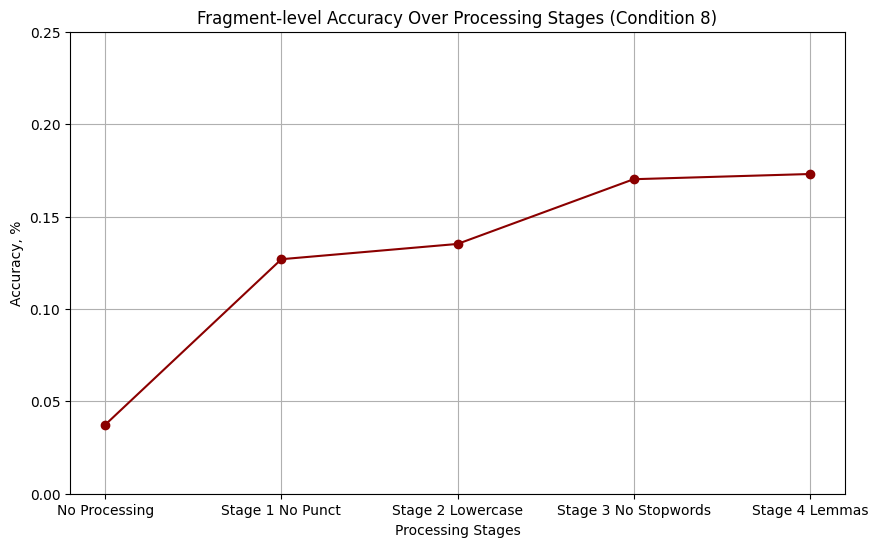

In [ ]:
import matplotlib.pyplot as plt
# List of accuracies
accuracies = [accuracy_score, accuracy_score_1, accuracy_score_2, accuracy_score_3, accuracy_score_4]

# List of processing stages
stages = ["No Processing", 'Stage 1 No Punct', 'Stage 2 Lowercase', 'Stage 3 No Stopwords', 'Stage 4 Lemmas']

# Create a line graph
plt.figure(figsize=(10, 6))
plt.plot(stages, accuracies, marker='o', linestyle='-', color='#8B0000')

# Adding title and labels
plt.title('Fragment-level Accuracy Over Processing Stages (Condition 8)')
plt.xlabel('Processing Stages')
plt.ylabel('Accuracy, %')

# Setting y-axis limits
plt.ylim(0, 0.25)

# Adding grid
plt.grid(True)

# Show the graph
plt.show()

# SI Task

The code below compares text spans in two datasets (Golden and Condition N) grouping them by article IDs. Thus, it allows to check how many text spans from the Golden dataset were captured by the model in each condition. It also calculated basic micro-level metrics, such as accuracy, precision, recall and F-1 score.

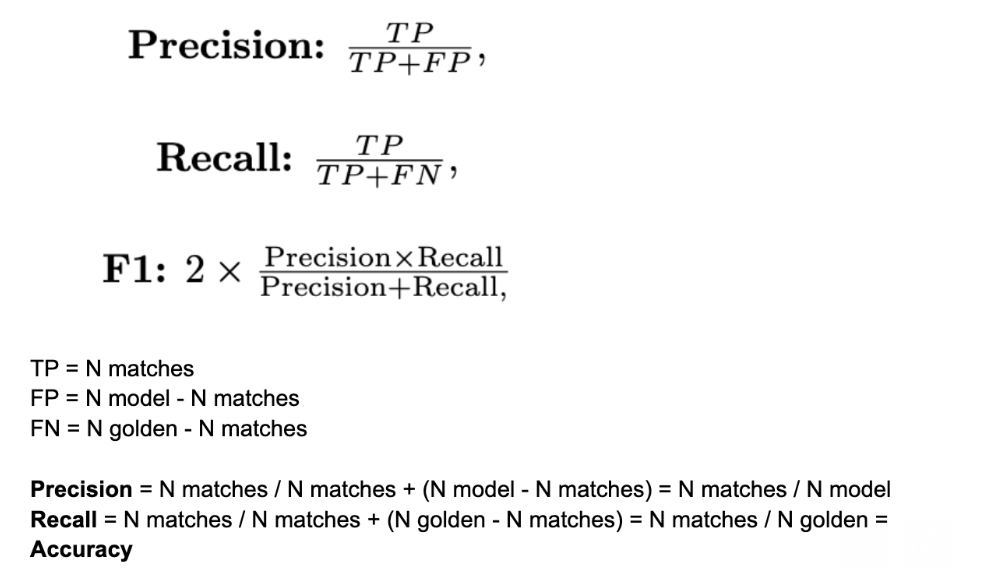



In [ ]:
def count_n_matches_and_calculate_metrics(golden_labels_df_filtered, df_filtered, processing_stage):
  # preprocess both dfs first
  preprocessed_golden_labels_df = preprocess_spans_by_steps(golden_labels_df_filtered.copy(), 'text_span')
  preprocessed_con_df = preprocess_spans_by_steps(df_filtered.copy(), 'Text Span')

  # check the number of entrie a.k.a. propaganda spans in both dfs
  print(f'There are {preprocessed_golden_labels_df.shape[0]} golden propaganda spans.')
  print(f'There are {preprocessed_con_df.shape[0]} propaganda spans identified by ChatGPT.')

  # correct the "no_propaganda_detected" rows in both dfs
  # golden
  technique_col_idx = preprocessed_golden_labels_df.columns.get_loc('technique')
  right_cols = preprocessed_golden_labels_df.columns[technique_col_idx + 1:]
  preprocessed_golden_labels_df.loc[preprocessed_golden_labels_df['technique'] == 'no_propaganda_detected', right_cols] = 'no_propaganda_detected'

  # model
  technique_col_idx_m = preprocessed_con_df.columns.get_loc('Propaganda Technique')
  right_cols_m = preprocessed_con_df.columns[technique_col_idx_m + 1:]
  preprocessed_con_df.loc[preprocessed_con_df['Propaganda Technique'] == 'no_propaganda_detected', right_cols_m] = 'no_propaganda_detected'


  def compare_text_spans(preprocessed_golden_labels_df, preprocessed_con_df, processing_stage):
    """
    Compare the text spans in the specified provessing stage column between the Golden Dataset and model's dataframe,
    based on the corresponding 'Article ID'.

    Returns:
    - updated_con_df: The model's outputs df with an additional column 'Present in Golden' indicating
      if the text span from the model's dataframe is present in the Golden df.
    """

    # ensure 'id' in and 'Article ID' are strings
    preprocessed_golden_labels_df['id'] = preprocessed_golden_labels_df['id'].astype(str)
    preprocessed_con_df['Article ID'] = preprocessed_con_df['Article ID'].astype(str)

    # create a dictionary from the golden df to group by 'id' and corresponding processing stage values
    golden_dict = preprocessed_golden_labels_df.groupby('id')[processing_stage].apply(list).to_dict()

    # define a function to check if the lemmatized text span exists in the corresponding preprocessed_con_df data for that article
    def check_presence(row):
        article_id = row['Article ID']
        lemmatized_text_span = row[processing_stage]
        return lemmatized_text_span in golden_dict.get(article_id, [])

    # apply the function to each row of the model dataframe
    preprocessed_con_df['Present in Golden'] = preprocessed_con_df.apply(check_presence, axis=1)

    return preprocessed_con_df

  # check how many text spans identified by the model are present in the golden dataset in the corresponding articles
  si_checked_con_df = compare_text_spans(preprocessed_golden_labels_df, preprocessed_con_df, processing_stage)
  matches_n = si_checked_con_df['Present in Golden'].apply(lambda x: x == True).sum()

  # n matches
  print(f'There are {matches_n} matches.')
  print()
  print()
  print()

  # calculate metrics
  """Precision = Number of Correct Model's Predictions / Total Number of Model's predictions.
     Recall = Number of Correct Model's Predictions a.k.a. matches / Total number of golden labels.
     (a.k.a. Total number of golen labels - Number of Correct Model's Predictions).
     F-1 Score =  2 * ((Precision*Recall) / (Precision+Recall))"""

  print('METRICS:')

  precision = round(matches_n / preprocessed_con_df.shape[0], 2)
  print(f'Precision: {precision}')
  print()

  recall = round(matches_n / preprocessed_golden_labels_df.shape[0], 2)
  print(f'Recall: {recall}')
  print()


  f1_score = round((2 * ((precision * recall) / (precision + recall))), 2)
  print(f'F-1 Score: {f1_score}')
  print()

In [ ]:
print(dfs_names[0])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con1_df_filtered, 'step_4_lemmatized')

Condition 1 (Base 0ne-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 5789 propaganda spans identified by ChatGPT.
There are 927 matches.



METRICS:
Precision: 0.16

Recall: 0.15

F-1 Score: 0.15



In [ ]:
print(dfs_names[1])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con2_df_filtered, 'step_4_lemmatized')

Condition 2 (Base Few-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 5691 propaganda spans identified by ChatGPT.
There are 907 matches.



METRICS:
Precision: 0.16

Recall: 0.15

F-1 Score: 0.15



In [ ]:
print(dfs_names[2])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con3_df_filtered, 'step_4_lemmatized')

Condition 3 (CoT One-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 3853 propaganda spans identified by ChatGPT.
There are 637 matches.



METRICS:
Precision: 0.17

Recall: 0.1

F-1 Score: 0.13



In [ ]:
print(dfs_names[3])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con4_df_filtered, 'step_4_lemmatized')

Condition 4 (CoT Few-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 3719 propaganda spans identified by ChatGPT.
There are 638 matches.



METRICS:
Precision: 0.17

Recall: 0.11

F-1 Score: 0.13



In [ ]:
print(dfs_names[4])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con5_df_filtered, 'step_4_lemmatized')

Condition 5 (Base One-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 6907 propaganda spans identified by ChatGPT.
There are 1450 matches.



METRICS:
Precision: 0.21

Recall: 0.24

F-1 Score: 0.22



In [ ]:
print(dfs_names[5])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con6_df_filtered, 'step_4_lemmatized')

Condition 6 (Base Few-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 7306 propaganda spans identified by ChatGPT.
There are 1300 matches.



METRICS:
Precision: 0.18

Recall: 0.21

F-1 Score: 0.19



In [ ]:
print(dfs_names[6])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con7_df_filtered, 'step_4_lemmatized')

Condition 7 (CoT One-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 4122 propaganda spans identified by ChatGPT.
There are 749 matches.



METRICS:
Precision: 0.18

Recall: 0.12

F-1 Score: 0.14



In [ ]:
print(dfs_names[7])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con8_df_filtered, 'step_4_lemmatized')

Condition 8 (CoT Few-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 3992 propaganda spans identified by ChatGPT.
There are 743 matches.



METRICS:
Precision: 0.19

Recall: 0.12

F-1 Score: 0.15



# TC Task

For the TC Task, the code for the SI task has been adopted and slightly changed. We took only the rows with the text spans proven to be present in the Golden dataset and checked whether the model assigned them the same propaganda techniques as in the Golden dataset. If so, we counted it as a total match.

In [ ]:
def compare_techniques_and_calculate_metrics(golden_labels_df_filtered, df_filtered, processing_stage):

  # preprocess both dfs
  preprocessed_golden_labels_df = preprocess_spans_by_steps(golden_labels_df_filtered.copy(), 'text_span')
  preprocessed_con_df = preprocess_spans_by_steps(df_filtered.copy(), 'Text Span')

  # correct the "no_propaganda_detected" rows in both dfs
  # golden
  technique_col_idx = preprocessed_golden_labels_df.columns.get_loc('technique')
  right_cols = preprocessed_golden_labels_df.columns[technique_col_idx + 1:]
  preprocessed_golden_labels_df.loc[preprocessed_golden_labels_df['technique'] == 'no_propaganda_detected', right_cols] = 'no_propaganda_detected'

  # model
  technique_col_idx_m = preprocessed_con_df.columns.get_loc('Propaganda Technique')
  right_cols_m = preprocessed_con_df.columns[technique_col_idx_m + 1:]
  preprocessed_con_df.loc[preprocessed_con_df['Propaganda Technique'] == 'no_propaganda_detected', right_cols_m] = 'no_propaganda_detected'

  def compare_text_spans(preprocessed_golden_labels_df, preprocessed_con_df, processing_stage):
    """
    Compare the text spans in the specified processing stage column between the Golden Dataset and model's dataframe,
    based on the corresponding 'Article ID'.

    Returns:
    - preprocessed_con_df: The model's outputs df with an additional column 'Present in Golden' indicating
      if the text span from the model's dataframe is present in the Golden df.
    """

    # ensure 'id' in and 'Article ID' are strings
    preprocessed_golden_labels_df['id'] = preprocessed_golden_labels_df['id'].astype(str)
    preprocessed_con_df['Article ID'] = preprocessed_con_df['Article ID'].astype(str)

    # create a dictionary from the golden df to group by 'id' and corresponding processing stage values
    golden_dict = preprocessed_golden_labels_df.groupby('id')[processing_stage].apply(list).to_dict()

    # define a function to check if the lemmatized text span exists in the corresponding preprocessed_con_df data for that article
    def check_presence(row):
        article_id = row['Article ID']
        lemmatized_text_span = row[processing_stage]
        return lemmatized_text_span in golden_dict.get(article_id, [])

    # apply the function to each row of the model dataframe
    preprocessed_con_df['Present in Golden'] = preprocessed_con_df.apply(check_presence, axis=1)

    return preprocessed_con_df

  # compare the text spans
  si_checked_con_df = compare_text_spans(preprocessed_golden_labels_df.copy(), preprocessed_con_df.copy(), 'step_4_lemmatized')
  si_checked_con_df_filtered = si_checked_con_df[si_checked_con_df['Present in Golden'] == True]

  # filter the rows the True values in the "Present in Golden" column
  si_checked_con_df_filtered = si_checked_con_df[si_checked_con_df['Present in Golden'] == True]

  # use the filtered df in the following function
  def compare_text_spans_and_techniques(preprocessed_golden_labels_df, si_checked_con_df_filtered, processing_stage):
    """
    Compare the text spans and techniques in the specified processing stage column between the Golden Dataset and model's dataframe,
    based on the corresponding 'Article ID'.

    Adds a column 'Technique check' to the model's dataframe indicating if the technique was correctly assigned.

    Returns:
    - full_check_con_df: The model's outputs df with an additional column 'Technique check'.
    """

    # Ensure 'id' and 'Article ID' are strings
    preprocessed_golden_labels_df['id'] = preprocessed_golden_labels_df['id'].astype(str)
    si_checked_con_df_filtered['Article ID'] = si_checked_con_df_filtered['Article ID'].astype(str)

    # Create a dictionary from the golden df to group by 'id' and corresponding processing stage values and techniques
    golden_dict = preprocessed_golden_labels_df.groupby('id')[[processing_stage, 'technique']].apply(lambda x: x.values.tolist()).to_dict()

    # Define a function to check if the lemmatized text span and technique exists in the corresponding golden data for that article
    def check_technique(row):
        article_id = row['Article ID']
        lemmatized_text_span = row[processing_stage]
        technique = row['Propaganda Technique']

        # Check if the (text span, technique) pair exists in the golden dictionary for the given article_id
        return [lemmatized_text_span, technique] in golden_dict.get(article_id, [])

    # Apply the function to each row of the model dataframe
    si_checked_con_df_filtered['Technique check'] = si_checked_con_df_filtered.apply(check_technique, axis=1)

    return si_checked_con_df_filtered

  full_check_con_df = compare_text_spans_and_techniques(preprocessed_golden_labels_df.copy(), si_checked_con_df_filtered.copy(), 'step_4_lemmatized')
  full_matches_n = full_check_con_df['Technique check'].sum()

  # n matches
  print(f'There are {full_matches_n} full matches.')
  print()
  print()
  # calculate metrics
  """Precision = Number of Correct Model's Predictions / Total Number of Model's predictions.
     Recall = Number of Correct Model's Predictions a.k.a. matches / Total number of golden labels.
     (a.k.a. Total number of golen labels - Number of Correct Model's Predictions).
     F-1 Score =  2 * ((Precision*Recall) / (Precision+Recall))"""

  print('METRICS:')

  precision = round(full_matches_n / preprocessed_con_df.shape[0], 2)
  print(f'Precision: {precision}')
  print()

  recall = round(full_matches_n / preprocessed_golden_labels_df.shape[0], 2)
  print(f'Recall: {recall}')
  print()


  f1_score = round((2 * ((precision * recall) / (precision + recall))), 2)
  print(f'F-1 Score: {f1_score}')
  print()

  return full_check_con_df

In [ ]:
print(dfs_names[0])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con1_df_filtered, 'step_4_lemmatized')

Condition 1 (Base 0ne-shot Temp0.7)
______________________
There are 398 full matches.


METRICS:
Precision: 0.07

Recall: 0.07

F-1 Score: 0.07



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,"name_calling,labeling",white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,True
1,701225819,"name_calling,labeling",hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,True
6,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
13,701225819,"exaggeration,minimisation",the greatest leader in modern Western history,True,the greatest leader in modern Western history,the greatest leader in modern western history,greatest leader modern western history,greatest leader modern western history,True,False
18,701225819,doubt,their toxic hate,True,their toxic hate,their toxic hate,toxic hate,toxic hate,True,False
...,...,...,...,...,...,...,...,...,...,...
6082,763280007,flag-waving,We will protect our people,True,We will protect our people,we will protect our people,protect people,protect people,True,False
6088,763280007,black-and-white_fallacy,unless this slide to totalitarianism is stoppe...,True,unless this slide to totalitarianism is stoppe...,unless this slide to totalitarianism is stoppe...,unless slide totalitarianism stopped,unless slide totalitarianism stopped,True,True
6094,763280007,doubt,the beginning of an authoritarian police state...,True,the beginning of an authoritarian police state...,the beginning of an authoritarian police state...,beginning authoritarian police state,beginning authoritarian police state,True,False
6101,763280007,flag-waving,We will not be silenced.,True,We will not be silenced,we will not be silenced,silenced,silenced,True,False


In [ ]:
print(dfs_names[1])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con2_df_filtered, 'step_4_lemmatized')

Condition 2 (Base Few-shot Temp0.7)
______________________
There are 382 full matches.


METRICS:
Precision: 0.07

Recall: 0.06

F-1 Score: 0.06



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,False
1,701225819,loaded_language,hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
4,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
5,701225819,loaded_language,Jewish Zionist Agent,True,Jewish Zionist Agent,jewish zionist agent,jewish zionist agent,jewish zionist agent,True,False
6,701225819,"name_calling,labeling",Jewish extremists,True,Jewish extremists,jewish extremists,jewish extremists,jewish extremist,True,True
...,...,...,...,...,...,...,...,...,...,...
5958,763280007,loaded_language,We will stand strong and do our duty.,True,We will stand strong and do our duty,we will stand strong and do our duty,stand strong duty,stand strong duty,True,False
5961,763280007,loaded_language,the future is ours and not yours.,True,the future is ours and not yours,the future is ours and not yours,future,future,True,False
5962,763280007,flag-waving,the future is ours and not yours.,True,the future is ours and not yours,the future is ours and not yours,future,future,True,True
5966,758756657,loaded_language,the most vicious and brutal ideology on the fa...,True,the most vicious and brutal ideology on the fa...,the most vicious and brutal ideology on the fa...,vicious brutal ideology face earth,vicious brutal ideology face earth,True,False


In [ ]:
print(dfs_names[2])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con3_df_filtered, 'step_4_lemmatized')

Condition 3 (CoT One-shot Temp0.7)
______________________
There are 257 full matches.


METRICS:
Precision: 0.07

Recall: 0.04

F-1 Score: 0.05



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
1,788056108,loaded_language,"""monster once known as Cardinal McCarrick""","The word ""monster"" is emotionally charged to p...",True,monster once known as Cardinal McCarrick,monster once known as cardinal mccarrick,monster known cardinal mccarrick,monster known cardinal mccarrick,True,False
2,788056108,"exaggeration,minimisation","""power-mad ecclesiastical tyrant""",The phrase exaggerates Bergoglio's characteris...,True,powermad ecclesiastical tyrant,powermad ecclesiastical tyrant,powermad ecclesiastical tyrant,powermad ecclesiastical tyrant,True,False
3,788056108,"name_calling,labeling","""preening, Internet-created neo-Catholic doyenne""",This label is derogatory and aims to diminish ...,True,preening Internetcreated neoCatholic doyenne,preening internetcreated neocatholic doyenne,preening internetcreated neocatholic doyenne,preening internetcreated neocatholic doyenne,True,True
15,788056108,loaded_language,"""massive evidence of his unspeakable crimes""","The phrases ""massive"" and ""unspeakable"" evoke ...",True,massive evidence of his unspeakable crimes,massive evidence of his unspeakable crimes,massive evidence unspeakable crimes,massive evidence unspeakable crime,True,False
16,788056108,loaded_language,"""the wolf the cardinals improvidently elected ...","Referring to Bergoglio as a ""wolf"" leverages l...",True,the wolf the cardinals improvidently elected Pope,the wolf the cardinals improvidently elected pope,wolf cardinals improvidently elected pope,wolf cardinal improvidently elected pope,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4163,777720051,loaded_language,horrifying compound,"The use of ""horrifying"" adds a strong emotiona...",True,horrifying compound,horrifying compound,horrifying compound,horrifying compound,True,True
4180,763280007,flag-waving,"""defend our civilization""",This phrase appeals to national or cultural pr...,True,defend our civilization,defend our civilization,defend civilization,defend civilization,True,False
4183,763280007,"exaggeration,minimisation","""the death of Britain as a free society""",This statement exaggerates the potential impac...,True,the death of Britain as a free society,the death of britain as a free society,death britain free society,death britain free society,True,False
4186,763280007,doubt,"""unless this slide to totalitarianism is stopp...","This introduces uncertainty about the future, ...",True,unless this slide to totalitarianism is stoppe...,unless this slide to totalitarianism is stoppe...,unless slide totalitarianism stopped,unless slide totalitarianism stopped,True,False


In [ ]:
print(dfs_names[3])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con4_df_filtered, 'step_4_lemmatized')

Condition 4 (CoT Few-shot Temp0.7)
______________________
There are 271 full matches.


METRICS:
Precision: 0.07

Recall: 0.04

F-1 Score: 0.05



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
34,708561738,loaded_language,How Do You Like Paying For Sexual Harassment S...,The question is phrased to provoke a strong em...,True,How Do You Like Paying For Sexual Harassment S...,how do you like paying for sexual harassment s...,like paying sexual harassment settlements cong...,like paying sexual harassment settlement congr...,True,False
35,708561738,loaded_language,epidemic of sexual harassment,"The word ""epidemic"" is used to invoke a sense ...",True,epidemic of sexual harassment,epidemic of sexual harassment,epidemic sexual harassment,epidemic sexual harassment,True,True
37,708561738,appeal_to_fear-prejudice,"For many in Congress, having so many attractiv...",This statement plays on fears and prejudices a...,True,For many in Congress having so many attractive...,for many in congress having so many attractive...,many congress many attractive young women arou...,many congress many attractive young woman arou...,True,False
43,710376094,loaded_language,"""Potentially Hazardous""","""Potentially Hazardous"" carries a strong emoti...",True,Potentially Hazardous,potentially hazardous,potentially hazardous,potentially hazardous,True,False
54,754179642,loaded_language,"""public health emergency with international im...",The phrase uses emotionally charged language t...,True,public health emergency with international impact,public health emergency with international impact,public health emergency international impact,public health emergency international impact,True,False
...,...,...,...,...,...,...,...,...,...,...,...
3948,763280007,flag-waving,"And we will protect our people.""",This text span uses strong national or cultura...,True,And we will protect our people,and we will protect our people,protect people,protect people,True,False
3954,763280007,doubt,"""If Wilders’ words don’t prove true, it will b...",This statement casts doubt on the future of fr...,True,If Wilders words dont prove true it will be be...,if wilders words dont prove true it will be be...,wilders words dont prove true death free socie...,wilder word dont prove true death free society...,True,False
3963,763412406,"name_calling,labeling","""political prisoner""","The term ""political prisoner"" labels Tommy Rob...",True,political prisoner,political prisoner,political prisoner,political prisoner,True,True
3965,763412406,flag-waving,"""The British are coming back!""",Utilizes national pride and identity to rally ...,True,The British are coming back,the british are coming back,british coming back,british coming back,True,True


In [ ]:
print(dfs_names[4])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con5_df_filtered, 'step_4_lemmatized')

Condition 5 (Base One-shot Temp 0)
______________________
There are 523 full matches.


METRICS:
Precision: 0.08

Recall: 0.09

F-1 Score: 0.08



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,False
1,701225819,loaded_language,hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
4,701225819,loaded_language,Jewish Zionist Agent,True,Jewish Zionist Agent,jewish zionist agent,jewish zionist agent,jewish zionist agent,True,False
5,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
9,701225819,loaded_language,wicked and filth-ridden,True,wicked and filthridden,wicked and filthridden,wicked filthridden,wicked filthridden,True,False
...,...,...,...,...,...,...,...,...,...,...
7206,773937361,loaded_language,"""grossly corrupt and evil men""",True,grossly corrupt and evil men,grossly corrupt and evil men,grossly corrupt evil men,grossly corrupt evil men,True,True
7209,773937361,loaded_language,"""manifestly evil and apostate men""",True,manifestly evil and apostate men,manifestly evil and apostate men,manifestly evil apostate men,manifestly evil apostate men,True,True
7213,773937361,"exaggeration,minimisation","""life-long homosexual rapist and sexual predator""",True,lifelong homosexual rapist and sexual predator,lifelong homosexual rapist and sexual predator,lifelong homosexual rapist sexual predator,lifelong homosexual rapist sexual predator,True,False
7214,773937361,"exaggeration,minimisation","""grossly corrupt and evil men""",True,grossly corrupt and evil men,grossly corrupt and evil men,grossly corrupt evil men,grossly corrupt evil men,True,False


In [ ]:
print(dfs_names[5])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con6_df_filtered, 'step_4_lemmatized')

Condition 6 (Base Few-shot Temp 0)
______________________
There are 545 full matches.


METRICS:
Precision: 0.07

Recall: 0.09

F-1 Score: 0.08



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,False
1,701225819,loaded_language,hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
3,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
6,701225819,loaded_language,wicked and filth-ridden,True,wicked and filthridden,wicked and filthridden,wicked filthridden,wicked filthridden,True,False
8,701225819,loaded_language,the greatest leader in modern Western history,True,the greatest leader in modern Western history,the greatest leader in modern western history,greatest leader modern western history,greatest leader modern western history,True,False
...,...,...,...,...,...,...,...,...,...,...
7683,789615291,loaded_language,trendoid socialists armed with torches and pit...,True,trendoid socialists armed with torches and pit...,trendoid socialists armed with torches and pit...,trendoid socialists armed torches pitchforks,trendoid socialist armed torch pitchfork,True,False
7684,789615291,loaded_language,confirmation circuses,True,confirmation circuses,confirmation circuses,confirmation circuses,confirmation circus,True,True
7686,789615291,loaded_language,shoot the alligator,True,shoot the alligator,shoot the alligator,shoot alligator,shoot alligator,True,True
7689,789615291,"name_calling,labeling",trendoid socialists armed with torches and pit...,True,trendoid socialists armed with torches and pit...,trendoid socialists armed with torches and pit...,trendoid socialists armed torches pitchforks,trendoid socialist armed torch pitchfork,True,True


In [ ]:
print(dfs_names[6])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con7_df_filtered, 'step_4_lemmatized')

Condition 7 (CoT One-shot Temp 0)
______________________
There are 337 full matches.


METRICS:
Precision: 0.08

Recall: 0.06

F-1 Score: 0.07



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,hatemonger,"The term ""hatemonger"" carries a strong negativ...",True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
2,701225819,loaded_language,venomous,"Describing the video as ""venomous"" uses emotio...",True,venomous,venomous,venomous,venomous,True,True
5,701225819,loaded_language,wicked and filth-ridden,This description of the Jewish religion is des...,True,wicked and filthridden,wicked and filthridden,wicked filthridden,wicked filthridden,True,False
6,701225819,loaded_language,hatemongering,"The term ""hatemongering"" is used to describe Z...",True,hatemongering,hatemongering,hatemongering,hatemongering,True,True
7,701225819,"name_calling,labeling",Jewish Zionist Agent,"Labeling someone as a ""Jewish Zionist Agent"" c...",True,Jewish Zionist Agent,jewish zionist agent,jewish zionist agent,jewish zionist agent,True,True
...,...,...,...,...,...,...,...,...,...,...,...
4313,763280007,flag-waving,"""We will defend our civilization.",This statement plays on nationalistic sentimen...,True,We will defend our civilization,we will defend our civilization,defend civilization,defend civilization,True,False
4314,763280007,flag-waving,"And we will protect our people.""",This statement plays on nationalistic sentimen...,True,And we will protect our people,and we will protect our people,protect people,protect people,True,False
4316,763280007,"exaggeration,minimisation","""the death of Britain as a free society""",This phrase exaggerates the potential conseque...,True,the death of Britain as a free society,the death of britain as a free society,death britain free society,death britain free society,True,False
4318,763280007,doubt,"""the beginning of an authoritarian police state""",This phrase casts doubt on the integrity and i...,True,the beginning of an authoritarian police state,the beginning of an authoritarian police state,beginning authoritarian police state,beginning authoritarian police state,True,False


In [ ]:
print(dfs_names[7])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con8_df_filtered, 'step_4_lemmatized')

Condition 8 (CoT Few-shot Temp 0)
______________________
There are 346 full matches.


METRICS:
Precision: 0.09

Recall: 0.06

F-1 Score: 0.07



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
35,708561738,loaded_language,How Do You Like Paying For Sexual Harassment S...,The phrase is emotionally charged to provoke a...,True,How Do You Like Paying For Sexual Harassment S...,how do you like paying for sexual harassment s...,like paying sexual harassment settlements cong...,like paying sexual harassment settlement congr...,True,False
36,708561738,loaded_language,epidemic of sexual harassment,"The word ""epidemic"" is used to evoke a strong ...",True,epidemic of sexual harassment,epidemic of sexual harassment,epidemic sexual harassment,epidemic sexual harassment,True,True
43,708561738,appeal_to_fear-prejudice,"For many in Congress, having so many attractiv...",This statement plays on fears and prejudices a...,True,For many in Congress having so many attractive...,for many in congress having so many attractive...,many congress many attractive young women arou...,many congress many attractive young woman arou...,True,False
45,708561738,loaded_language,sex trade on Capitol Hill,"The term ""sex trade"" is heavily loaded to evok...",True,sex trade on Capitol Hill,sex trade on capitol hill,sex trade capitol hill,sex trade capitol hill,True,False
47,710376094,loaded_language,“Potentially Hazardous”,"The phrase ""potentially hazardous"" is used to ...",True,Potentially Hazardous,potentially hazardous,potentially hazardous,potentially hazardous,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4063,763280007,flag-waving,"""We will never surrender.",This rhetoric is used to rally nationalistic a...,True,We will never surrender,we will never surrender,never surrender,never surrender,True,False
4064,763280007,flag-waving,"We will stand strong and do our duty.""",This rhetoric is used to rally nationalistic a...,True,We will stand strong and do our duty,we will stand strong and do our duty,stand strong duty,stand strong duty,True,False
4066,763280007,"exaggeration,minimisation","""the beginning of an authoritarian police state""",This phrase exaggerates the political situatio...,True,the beginning of an authoritarian police state,the beginning of an authoritarian police state,beginning authoritarian police state,beginning authoritarian police state,True,False
4068,763280007,flag-waving,"""the future is ours and not yours.""",This statement uses strong group identity to p...,True,the future is ours and not yours,the future is ours and not yours,future,future,True,True


# SI second option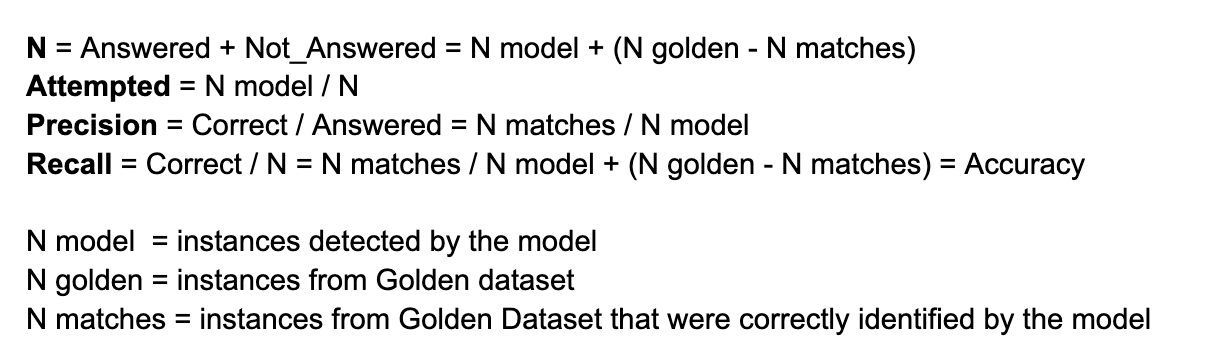

In [ ]:
def count_n_matches_and_calculate_metrics(golden_labels_df_filtered, df_filtered, processing_stage):
  # preprocess both dfs first
  preprocessed_golden_labels_df = preprocess_spans_by_steps(golden_labels_df_filtered.copy(), 'text_span')
  preprocessed_con_df = preprocess_spans_by_steps(df_filtered.copy(), 'Text Span')

  # check the number of entrie a.k.a. propaganda spans in both dfs
  print(f'There are {preprocessed_golden_labels_df.shape[0]} golden propaganda spans.')
  print(f'There are {preprocessed_con_df.shape[0]} propaganda spans identified by ChatGPT.')

  # correct the "no_propaganda_detected" rows in both dfs
  # golden
  technique_col_idx = preprocessed_golden_labels_df.columns.get_loc('technique')
  right_cols = preprocessed_golden_labels_df.columns[technique_col_idx + 1:]
  preprocessed_golden_labels_df.loc[preprocessed_golden_labels_df['technique'] == 'no_propaganda_detected', right_cols] = 'no_propaganda_detected'

  # model
  technique_col_idx_m = preprocessed_con_df.columns.get_loc('Propaganda Technique')
  right_cols_m = preprocessed_con_df.columns[technique_col_idx_m + 1:]
  preprocessed_con_df.loc[preprocessed_con_df['Propaganda Technique'] == 'no_propaganda_detected', right_cols_m] = 'no_propaganda_detected'


  def compare_text_spans(preprocessed_golden_labels_df, preprocessed_con_df, processing_stage):
    """
    Compare the text spans in the specified provessing stage column between the Golden Dataset and model's dataframe,
    based on the corresponding 'Article ID'.

    Returns:
    - updated_con_df: The model's outputs df with an additional column 'Present in Golden' indicating
      if the text span from the model's dataframe is present in the Golden df.
    """

    # ensure 'id' in and 'Article ID' are strings
    preprocessed_golden_labels_df['id'] = preprocessed_golden_labels_df['id'].astype(str)
    preprocessed_con_df['Article ID'] = preprocessed_con_df['Article ID'].astype(str)

    # create a dictionary from the golden df to group by 'id' and corresponding processing stage values
    golden_dict = preprocessed_golden_labels_df.groupby('id')[processing_stage].apply(list).to_dict()

    # define a function to check if the lemmatized text span exists in the corresponding preprocessed_con_df data for that article
    def check_presence(row):
        article_id = row['Article ID']
        lemmatized_text_span = row[processing_stage]
        return lemmatized_text_span in golden_dict.get(article_id, [])

    # apply the function to each row of the model dataframe
    preprocessed_con_df['Present in Golden'] = preprocessed_con_df.apply(check_presence, axis=1)

    return preprocessed_con_df

  # check how many text spans identified by the model are present in the golden dataset in the corresponding articles
  si_checked_con_df = compare_text_spans(preprocessed_golden_labels_df, preprocessed_con_df, processing_stage)
  matches_n = si_checked_con_df['Present in Golden'].apply(lambda x: x == True).sum()

  # n matches
  print(f'There are {matches_n} matches.')
  print()
  print()
  print()

  # calculate metrics
  """Precision = Number of Correct Model's Predictions / Total Number of Model's predictions.
     Recall = Number of Correct Model's Predictions a.k.a. matches / (N model + (N golden - N matches)).
     (a.k.a. Total number of golen labels - Number of Correct Model's Predictions).
     F-1 Score =  2 * ((Precision*Recall) / (Precision+Recall))"""

  print('METRICS:')

  precision = round(matches_n / preprocessed_con_df.shape[0], 2)
  print(f'Precision: {precision}')
  print()

  recall = round(matches_n / (preprocessed_con_df.shape[0] + (preprocessed_golden_labels_df.shape[0] - matches_n)), 2)
  print(f'Recall: {recall}')
  print()


  f1_score = round((2 * ((precision * recall) / (precision + recall))), 2)
  print(f'F-1 Score: {f1_score}')
  print()

In [ ]:
print(dfs_names[0])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con1_df_filtered, 'step_4_lemmatized')

Condition 1 (Base 0ne-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 5789 propaganda spans identified by ChatGPT.
There are 927 matches.



METRICS:
Precision: 0.16

Recall: 0.08

F-1 Score: 0.11



In [ ]:
print(dfs_names[1])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con2_df_filtered, 'step_4_lemmatized')

Condition 2 (Base Few-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 5691 propaganda spans identified by ChatGPT.
There are 907 matches.



METRICS:
Precision: 0.16

Recall: 0.08

F-1 Score: 0.11



In [ ]:
print(dfs_names[2])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con3_df_filtered, 'step_4_lemmatized')

Condition 3 (CoT One-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 3853 propaganda spans identified by ChatGPT.
There are 637 matches.



METRICS:
Precision: 0.17

Recall: 0.07

F-1 Score: 0.1



In [ ]:
print(dfs_names[3])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con4_df_filtered, 'step_4_lemmatized')

Condition 4 (CoT Few-shot Temp0.7)
______________________
There are 6067 golden propaganda spans.
There are 3719 propaganda spans identified by ChatGPT.
There are 638 matches.



METRICS:
Precision: 0.17

Recall: 0.07

F-1 Score: 0.1



In [ ]:
print(dfs_names[4])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con5_df_filtered, 'step_4_lemmatized')

Condition 5 (Base One-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 6907 propaganda spans identified by ChatGPT.
There are 1450 matches.



METRICS:
Precision: 0.21

Recall: 0.13

F-1 Score: 0.16



In [ ]:
print(dfs_names[5])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con4_df_filtered, 'step_4_lemmatized')

Condition 6 (Base Few-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 3719 propaganda spans identified by ChatGPT.
There are 638 matches.



METRICS:
Precision: 0.17

Recall: 0.07

F-1 Score: 0.1



In [ ]:
print(dfs_names[6])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con7_df_filtered, 'step_4_lemmatized')

Condition 7 (CoT One-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 4122 propaganda spans identified by ChatGPT.
There are 749 matches.



METRICS:
Precision: 0.18

Recall: 0.08

F-1 Score: 0.11



In [ ]:
print(dfs_names[7])
print('______________________')
count_n_matches_and_calculate_metrics(golden_labels_df_filtered, con8_df_filtered, 'step_4_lemmatized')

Condition 8 (CoT Few-shot Temp 0)
______________________
There are 6067 golden propaganda spans.
There are 3992 propaganda spans identified by ChatGPT.
There are 743 matches.



METRICS:
Precision: 0.19

Recall: 0.08

F-1 Score: 0.11



# TC second option

In [ ]:
def compare_techniques_and_calculate_metrics(golden_labels_df_filtered, df_filtered, processing_stage):

  # preprocess both dfs
  preprocessed_golden_labels_df = preprocess_spans_by_steps(golden_labels_df_filtered.copy(), 'text_span')
  preprocessed_con_df = preprocess_spans_by_steps(df_filtered.copy(), 'Text Span')

  # correct the "no_propaganda_detected" rows in both dfs
  # golden
  technique_col_idx = preprocessed_golden_labels_df.columns.get_loc('technique')
  right_cols = preprocessed_golden_labels_df.columns[technique_col_idx + 1:]
  preprocessed_golden_labels_df.loc[preprocessed_golden_labels_df['technique'] == 'no_propaganda_detected', right_cols] = 'no_propaganda_detected'

  # model
  technique_col_idx_m = preprocessed_con_df.columns.get_loc('Propaganda Technique')
  right_cols_m = preprocessed_con_df.columns[technique_col_idx_m + 1:]
  preprocessed_con_df.loc[preprocessed_con_df['Propaganda Technique'] == 'no_propaganda_detected', right_cols_m] = 'no_propaganda_detected'

  def compare_text_spans(preprocessed_golden_labels_df, preprocessed_con_df, processing_stage):
    """
    Compare the text spans in the specified processing stage column between the Golden Dataset and model's dataframe,
    based on the corresponding 'Article ID'.

    Returns:
    - preprocessed_con_df: The model's outputs df with an additional column 'Present in Golden' indicating
      if the text span from the model's dataframe is present in the Golden df.
    """

    # ensure 'id' in and 'Article ID' are strings
    preprocessed_golden_labels_df['id'] = preprocessed_golden_labels_df['id'].astype(str)
    preprocessed_con_df['Article ID'] = preprocessed_con_df['Article ID'].astype(str)

    # create a dictionary from the golden df to group by 'id' and corresponding processing stage values
    golden_dict = preprocessed_golden_labels_df.groupby('id')[processing_stage].apply(list).to_dict()

    # define a function to check if the lemmatized text span exists in the corresponding preprocessed_con_df data for that article
    def check_presence(row):
        article_id = row['Article ID']
        lemmatized_text_span = row[processing_stage]
        return lemmatized_text_span in golden_dict.get(article_id, [])

    # apply the function to each row of the model dataframe
    preprocessed_con_df['Present in Golden'] = preprocessed_con_df.apply(check_presence, axis=1)

    return preprocessed_con_df

  # compare the text spans
  si_checked_con_df = compare_text_spans(preprocessed_golden_labels_df.copy(), preprocessed_con_df.copy(), 'step_4_lemmatized')
  si_checked_con_df_filtered = si_checked_con_df[si_checked_con_df['Present in Golden'] == True]

  # filter the rows the True values in the "Present in Golden" column
  si_checked_con_df_filtered = si_checked_con_df[si_checked_con_df['Present in Golden'] == True]

  # use the filtered df in the following function
  def compare_text_spans_and_techniques(preprocessed_golden_labels_df, si_checked_con_df_filtered, processing_stage):
    """
    Compare the text spans and techniques in the specified processing stage column between the Golden Dataset and model's dataframe,
    based on the corresponding 'Article ID'.

    Adds a column 'Technique check' to the model's dataframe indicating if the technique was correctly assigned.

    Returns:
    - full_check_con_df: The model's outputs df with an additional column 'Technique check'.
    """

    # Ensure 'id' and 'Article ID' are strings
    preprocessed_golden_labels_df['id'] = preprocessed_golden_labels_df['id'].astype(str)
    si_checked_con_df_filtered['Article ID'] = si_checked_con_df_filtered['Article ID'].astype(str)

    # Create a dictionary from the golden df to group by 'id' and corresponding processing stage values and techniques
    golden_dict = preprocessed_golden_labels_df.groupby('id')[[processing_stage, 'technique']].apply(lambda x: x.values.tolist()).to_dict()

    # Define a function to check if the lemmatized text span and technique exists in the corresponding golden data for that article
    def check_technique(row):
        article_id = row['Article ID']
        lemmatized_text_span = row[processing_stage]
        technique = row['Propaganda Technique']

        # Check if the (text span, technique) pair exists in the golden dictionary for the given article_id
        return [lemmatized_text_span, technique] in golden_dict.get(article_id, [])

    # Apply the function to each row of the model dataframe
    si_checked_con_df_filtered['Technique check'] = si_checked_con_df_filtered.apply(check_technique, axis=1)

    return si_checked_con_df_filtered

  full_check_con_df = compare_text_spans_and_techniques(preprocessed_golden_labels_df.copy(), si_checked_con_df_filtered.copy(), 'step_4_lemmatized')
  full_matches_n = full_check_con_df['Technique check'].sum()

  # n matches
  print(f'There are {full_matches_n} full matches.')
  print()
  print()
  # calculate metrics
  """Precision = Number of Correct Model's Predictions / Total Number of Model's predictions.
     Recall = Number of Correct Model's Predictions a.k.a. matches / Total number of golden labels.
     (a.k.a. Total number of golen labels - Number of Correct Model's Predictions).
     F-1 Score =  2 * ((Precision*Recall) / (Precision+Recall))"""

  print('METRICS:')

  precision = round(full_matches_n / preprocessed_con_df.shape[0], 2)
  print(f'Precision: {precision}')
  print()

  recall = round(full_matches_n / (preprocessed_con_df.shape[0] + (preprocessed_golden_labels_df.shape[0] - full_matches_n)), 2)
  print(f'Recall: {recall}')
  print()


  f1_score = round((2 * ((precision * recall) / (precision + recall))), 2)
  print(f'F-1 Score: {f1_score}')
  print()

  return full_check_con_df

In [ ]:
print(dfs_names[0])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con1_df_filtered, 'step_4_lemmatized')

Condition 1 (Base 0ne-shot Temp0.7)
______________________
There are 398 full matches.


METRICS:
Precision: 0.07

Recall: 0.03

F-1 Score: 0.04



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,"name_calling,labeling",white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,True
1,701225819,"name_calling,labeling",hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,True
6,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
13,701225819,"exaggeration,minimisation",the greatest leader in modern Western history,True,the greatest leader in modern Western history,the greatest leader in modern western history,greatest leader modern western history,greatest leader modern western history,True,False
18,701225819,doubt,their toxic hate,True,their toxic hate,their toxic hate,toxic hate,toxic hate,True,False
...,...,...,...,...,...,...,...,...,...,...
6082,763280007,flag-waving,We will protect our people,True,We will protect our people,we will protect our people,protect people,protect people,True,False
6088,763280007,black-and-white_fallacy,unless this slide to totalitarianism is stoppe...,True,unless this slide to totalitarianism is stoppe...,unless this slide to totalitarianism is stoppe...,unless slide totalitarianism stopped,unless slide totalitarianism stopped,True,True
6094,763280007,doubt,the beginning of an authoritarian police state...,True,the beginning of an authoritarian police state...,the beginning of an authoritarian police state...,beginning authoritarian police state,beginning authoritarian police state,True,False
6101,763280007,flag-waving,We will not be silenced.,True,We will not be silenced,we will not be silenced,silenced,silenced,True,False


In [ ]:
print(dfs_names[1])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con2_df_filtered, 'step_4_lemmatized')

Condition 2 (Base Few-shot Temp0.7)
______________________
There are 382 full matches.


METRICS:
Precision: 0.07

Recall: 0.03

F-1 Score: 0.04



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,False
1,701225819,loaded_language,hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
4,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
5,701225819,loaded_language,Jewish Zionist Agent,True,Jewish Zionist Agent,jewish zionist agent,jewish zionist agent,jewish zionist agent,True,False
6,701225819,"name_calling,labeling",Jewish extremists,True,Jewish extremists,jewish extremists,jewish extremists,jewish extremist,True,True
...,...,...,...,...,...,...,...,...,...,...
5958,763280007,loaded_language,We will stand strong and do our duty.,True,We will stand strong and do our duty,we will stand strong and do our duty,stand strong duty,stand strong duty,True,False
5961,763280007,loaded_language,the future is ours and not yours.,True,the future is ours and not yours,the future is ours and not yours,future,future,True,False
5962,763280007,flag-waving,the future is ours and not yours.,True,the future is ours and not yours,the future is ours and not yours,future,future,True,True
5966,758756657,loaded_language,the most vicious and brutal ideology on the fa...,True,the most vicious and brutal ideology on the fa...,the most vicious and brutal ideology on the fa...,vicious brutal ideology face earth,vicious brutal ideology face earth,True,False


In [ ]:
print(dfs_names[2])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con3_df_filtered, 'step_4_lemmatized')

Condition 3 (CoT One-shot Temp0.7)
______________________
There are 257 full matches.


METRICS:
Precision: 0.07

Recall: 0.03

F-1 Score: 0.04



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
1,788056108,loaded_language,"""monster once known as Cardinal McCarrick""","The word ""monster"" is emotionally charged to p...",True,monster once known as Cardinal McCarrick,monster once known as cardinal mccarrick,monster known cardinal mccarrick,monster known cardinal mccarrick,True,False
2,788056108,"exaggeration,minimisation","""power-mad ecclesiastical tyrant""",The phrase exaggerates Bergoglio's characteris...,True,powermad ecclesiastical tyrant,powermad ecclesiastical tyrant,powermad ecclesiastical tyrant,powermad ecclesiastical tyrant,True,False
3,788056108,"name_calling,labeling","""preening, Internet-created neo-Catholic doyenne""",This label is derogatory and aims to diminish ...,True,preening Internetcreated neoCatholic doyenne,preening internetcreated neocatholic doyenne,preening internetcreated neocatholic doyenne,preening internetcreated neocatholic doyenne,True,True
15,788056108,loaded_language,"""massive evidence of his unspeakable crimes""","The phrases ""massive"" and ""unspeakable"" evoke ...",True,massive evidence of his unspeakable crimes,massive evidence of his unspeakable crimes,massive evidence unspeakable crimes,massive evidence unspeakable crime,True,False
16,788056108,loaded_language,"""the wolf the cardinals improvidently elected ...","Referring to Bergoglio as a ""wolf"" leverages l...",True,the wolf the cardinals improvidently elected Pope,the wolf the cardinals improvidently elected pope,wolf cardinals improvidently elected pope,wolf cardinal improvidently elected pope,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4163,777720051,loaded_language,horrifying compound,"The use of ""horrifying"" adds a strong emotiona...",True,horrifying compound,horrifying compound,horrifying compound,horrifying compound,True,True
4180,763280007,flag-waving,"""defend our civilization""",This phrase appeals to national or cultural pr...,True,defend our civilization,defend our civilization,defend civilization,defend civilization,True,False
4183,763280007,"exaggeration,minimisation","""the death of Britain as a free society""",This statement exaggerates the potential impac...,True,the death of Britain as a free society,the death of britain as a free society,death britain free society,death britain free society,True,False
4186,763280007,doubt,"""unless this slide to totalitarianism is stopp...","This introduces uncertainty about the future, ...",True,unless this slide to totalitarianism is stoppe...,unless this slide to totalitarianism is stoppe...,unless slide totalitarianism stopped,unless slide totalitarianism stopped,True,False


In [ ]:
print(dfs_names[3])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con4_df_filtered, 'step_4_lemmatized')

Condition 4 (CoT Few-shot Temp0.7)
______________________
There are 271 full matches.


METRICS:
Precision: 0.07

Recall: 0.03

F-1 Score: 0.04



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
34,708561738,loaded_language,How Do You Like Paying For Sexual Harassment S...,The question is phrased to provoke a strong em...,True,How Do You Like Paying For Sexual Harassment S...,how do you like paying for sexual harassment s...,like paying sexual harassment settlements cong...,like paying sexual harassment settlement congr...,True,False
35,708561738,loaded_language,epidemic of sexual harassment,"The word ""epidemic"" is used to invoke a sense ...",True,epidemic of sexual harassment,epidemic of sexual harassment,epidemic sexual harassment,epidemic sexual harassment,True,True
37,708561738,appeal_to_fear-prejudice,"For many in Congress, having so many attractiv...",This statement plays on fears and prejudices a...,True,For many in Congress having so many attractive...,for many in congress having so many attractive...,many congress many attractive young women arou...,many congress many attractive young woman arou...,True,False
43,710376094,loaded_language,"""Potentially Hazardous""","""Potentially Hazardous"" carries a strong emoti...",True,Potentially Hazardous,potentially hazardous,potentially hazardous,potentially hazardous,True,False
54,754179642,loaded_language,"""public health emergency with international im...",The phrase uses emotionally charged language t...,True,public health emergency with international impact,public health emergency with international impact,public health emergency international impact,public health emergency international impact,True,False
...,...,...,...,...,...,...,...,...,...,...,...
3948,763280007,flag-waving,"And we will protect our people.""",This text span uses strong national or cultura...,True,And we will protect our people,and we will protect our people,protect people,protect people,True,False
3954,763280007,doubt,"""If Wilders’ words don’t prove true, it will b...",This statement casts doubt on the future of fr...,True,If Wilders words dont prove true it will be be...,if wilders words dont prove true it will be be...,wilders words dont prove true death free socie...,wilder word dont prove true death free society...,True,False
3963,763412406,"name_calling,labeling","""political prisoner""","The term ""political prisoner"" labels Tommy Rob...",True,political prisoner,political prisoner,political prisoner,political prisoner,True,True
3965,763412406,flag-waving,"""The British are coming back!""",Utilizes national pride and identity to rally ...,True,The British are coming back,the british are coming back,british coming back,british coming back,True,True


In [ ]:
print(dfs_names[4])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con5_df_filtered, 'step_4_lemmatized')

Condition 5 (Base One-shot Temp 0)
______________________
There are 523 full matches.


METRICS:
Precision: 0.08

Recall: 0.04

F-1 Score: 0.05



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,False
1,701225819,loaded_language,hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
4,701225819,loaded_language,Jewish Zionist Agent,True,Jewish Zionist Agent,jewish zionist agent,jewish zionist agent,jewish zionist agent,True,False
5,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
9,701225819,loaded_language,wicked and filth-ridden,True,wicked and filthridden,wicked and filthridden,wicked filthridden,wicked filthridden,True,False
...,...,...,...,...,...,...,...,...,...,...
7206,773937361,loaded_language,"""grossly corrupt and evil men""",True,grossly corrupt and evil men,grossly corrupt and evil men,grossly corrupt evil men,grossly corrupt evil men,True,True
7209,773937361,loaded_language,"""manifestly evil and apostate men""",True,manifestly evil and apostate men,manifestly evil and apostate men,manifestly evil apostate men,manifestly evil apostate men,True,True
7213,773937361,"exaggeration,minimisation","""life-long homosexual rapist and sexual predator""",True,lifelong homosexual rapist and sexual predator,lifelong homosexual rapist and sexual predator,lifelong homosexual rapist sexual predator,lifelong homosexual rapist sexual predator,True,False
7214,773937361,"exaggeration,minimisation","""grossly corrupt and evil men""",True,grossly corrupt and evil men,grossly corrupt and evil men,grossly corrupt evil men,grossly corrupt evil men,True,False


In [ ]:
print(dfs_names[5])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con6_df_filtered, 'step_4_lemmatized')

Condition 6 (Base Few-shot Temp 0)
______________________
There are 545 full matches.


METRICS:
Precision: 0.07

Recall: 0.04

F-1 Score: 0.05



,Article ID,Propaganda Technique,Text Span,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,white supremacist icon,True,white supremacist icon,white supremacist icon,white supremacist icon,white supremacist icon,True,False
1,701225819,loaded_language,hatemonger,True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
3,701225819,loaded_language,venomous,True,venomous,venomous,venomous,venomous,True,True
6,701225819,loaded_language,wicked and filth-ridden,True,wicked and filthridden,wicked and filthridden,wicked filthridden,wicked filthridden,True,False
8,701225819,loaded_language,the greatest leader in modern Western history,True,the greatest leader in modern Western history,the greatest leader in modern western history,greatest leader modern western history,greatest leader modern western history,True,False
...,...,...,...,...,...,...,...,...,...,...
7683,789615291,loaded_language,trendoid socialists armed with torches and pit...,True,trendoid socialists armed with torches and pit...,trendoid socialists armed with torches and pit...,trendoid socialists armed torches pitchforks,trendoid socialist armed torch pitchfork,True,False
7684,789615291,loaded_language,confirmation circuses,True,confirmation circuses,confirmation circuses,confirmation circuses,confirmation circus,True,True
7686,789615291,loaded_language,shoot the alligator,True,shoot the alligator,shoot the alligator,shoot alligator,shoot alligator,True,True
7689,789615291,"name_calling,labeling",trendoid socialists armed with torches and pit...,True,trendoid socialists armed with torches and pit...,trendoid socialists armed with torches and pit...,trendoid socialists armed torches pitchforks,trendoid socialist armed torch pitchfork,True,True


In [ ]:
print(dfs_names[6])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con7_df_filtered, 'step_4_lemmatized')

Condition 7 (CoT One-shot Temp 0)
______________________
There are 337 full matches.


METRICS:
Precision: 0.08

Recall: 0.03

F-1 Score: 0.04



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
0,701225819,loaded_language,hatemonger,"The term ""hatemonger"" carries a strong negativ...",True,hatemonger,hatemonger,hatemonger,hatemonger,True,False
2,701225819,loaded_language,venomous,"Describing the video as ""venomous"" uses emotio...",True,venomous,venomous,venomous,venomous,True,True
5,701225819,loaded_language,wicked and filth-ridden,This description of the Jewish religion is des...,True,wicked and filthridden,wicked and filthridden,wicked filthridden,wicked filthridden,True,False
6,701225819,loaded_language,hatemongering,"The term ""hatemongering"" is used to describe Z...",True,hatemongering,hatemongering,hatemongering,hatemongering,True,True
7,701225819,"name_calling,labeling",Jewish Zionist Agent,"Labeling someone as a ""Jewish Zionist Agent"" c...",True,Jewish Zionist Agent,jewish zionist agent,jewish zionist agent,jewish zionist agent,True,True
...,...,...,...,...,...,...,...,...,...,...,...
4313,763280007,flag-waving,"""We will defend our civilization.",This statement plays on nationalistic sentimen...,True,We will defend our civilization,we will defend our civilization,defend civilization,defend civilization,True,False
4314,763280007,flag-waving,"And we will protect our people.""",This statement plays on nationalistic sentimen...,True,And we will protect our people,and we will protect our people,protect people,protect people,True,False
4316,763280007,"exaggeration,minimisation","""the death of Britain as a free society""",This phrase exaggerates the potential conseque...,True,the death of Britain as a free society,the death of britain as a free society,death britain free society,death britain free society,True,False
4318,763280007,doubt,"""the beginning of an authoritarian police state""",This phrase casts doubt on the integrity and i...,True,the beginning of an authoritarian police state,the beginning of an authoritarian police state,beginning authoritarian police state,beginning authoritarian police state,True,False


In [ ]:
print(dfs_names[7])
print('______________________')
compare_techniques_and_calculate_metrics(golden_labels_df_filtered, con8_df_filtered, 'step_4_lemmatized')

Condition 8 (CoT Few-shot Temp 0)
______________________
There are 346 full matches.


METRICS:
Precision: 0.09

Recall: 0.04

F-1 Score: 0.06



,Article ID,Propaganda Technique,Text Span,Explanation,Text Span Presence,step_1_no_punct,step_2_lowercase,step_3_no_stopwords,step_4_lemmatized,Present in Golden,Technique check
35,708561738,loaded_language,How Do You Like Paying For Sexual Harassment S...,The phrase is emotionally charged to provoke a...,True,How Do You Like Paying For Sexual Harassment S...,how do you like paying for sexual harassment s...,like paying sexual harassment settlements cong...,like paying sexual harassment settlement congr...,True,False
36,708561738,loaded_language,epidemic of sexual harassment,"The word ""epidemic"" is used to evoke a strong ...",True,epidemic of sexual harassment,epidemic of sexual harassment,epidemic sexual harassment,epidemic sexual harassment,True,True
43,708561738,appeal_to_fear-prejudice,"For many in Congress, having so many attractiv...",This statement plays on fears and prejudices a...,True,For many in Congress having so many attractive...,for many in congress having so many attractive...,many congress many attractive young women arou...,many congress many attractive young woman arou...,True,False
45,708561738,loaded_language,sex trade on Capitol Hill,"The term ""sex trade"" is heavily loaded to evok...",True,sex trade on Capitol Hill,sex trade on capitol hill,sex trade capitol hill,sex trade capitol hill,True,False
47,710376094,loaded_language,“Potentially Hazardous”,"The phrase ""potentially hazardous"" is used to ...",True,Potentially Hazardous,potentially hazardous,potentially hazardous,potentially hazardous,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4063,763280007,flag-waving,"""We will never surrender.",This rhetoric is used to rally nationalistic a...,True,We will never surrender,we will never surrender,never surrender,never surrender,True,False
4064,763280007,flag-waving,"We will stand strong and do our duty.""",This rhetoric is used to rally nationalistic a...,True,We will stand strong and do our duty,we will stand strong and do our duty,stand strong duty,stand strong duty,True,False
4066,763280007,"exaggeration,minimisation","""the beginning of an authoritarian police state""",This phrase exaggerates the political situatio...,True,the beginning of an authoritarian police state,the beginning of an authoritarian police state,beginning authoritarian police state,beginning authoritarian police state,True,False
4068,763280007,flag-waving,"""the future is ours and not yours.""",This statement uses strong group identity to p...,True,the future is ours and not yours,the future is ours and not yours,future,future,True,True
